# NEURAL NETWORKS 21 APR 2021

In [1]:
import tensorflow as tf

In [3]:
print(tf.version.VERSION)

2.4.1


In [4]:
from tensorflow import keras

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

In [6]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [7]:
## Get my working directory
import os
path = os.getcwd()

In [9]:
os.chdir('C:/Pablo UK/46 DATA SCIENCE all/44 Python')

In [10]:
# Sales_clean.to_csv (r'Sales_clean_plot_csv.csv', index = False, header=True)

In [11]:
Sales_clean  = pd.read_csv('Sales_clean_plot_csv.csv') 

In [12]:
pivot = Sales_clean.copy()

In [13]:
pivot.head()

,PERIOD,Orgname,StoreCode,Sales
0,2016-05-30,East coast branch,LA2,145.0
1,2016-05-31,East coast branch,LA2,158.0
2,2016-06-01,East coast branch,LA2,154.0
3,2016-06-02,East coast branch,LA2,152.0
4,2016-06-03,East coast branch,LA2,147.0


In [14]:
SalesP = pd.pivot_table(Sales_clean, 
                        values = 'Sales', 
                        index=['PERIOD'], 
                        columns = 'Orgname').reset_index()

In [15]:
SalesP['PERIOD'] = pd.to_datetime(SalesP['PERIOD'])

In [16]:
SalesP.set_index("PERIOD",inplace=True)

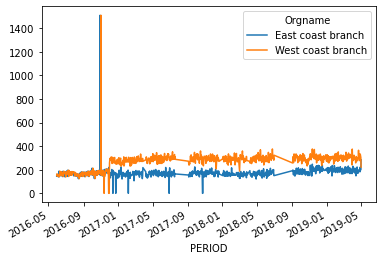

In [17]:
SalesP.plot()

In [20]:
SalesQ = SalesP.copy()

In [21]:
SalesP.head()

Orgname,East coast branch,West coast branch
PERIOD,,
2016-05-30,145.0,152.0
2016-05-31,158.0,164.0
2016-06-01,154.0,NaN
2016-06-02,152.0,145.0
2016-06-03,147.0,158.0


In [22]:
SalesP.rename(columns={'East coast branch':'Eastbranch'},inplace=True)

In [24]:
SalesP.rename(columns={'West coast branch':'Westbranch'},inplace=True)

In [29]:
SalesP.head()

Orgname,Eastbranch,Westbranch
PERIOD,,
2016-05-30,145.0,152.0
2016-05-31,158.0,164.0
2016-06-01,154.0,NaN
2016-06-02,152.0,145.0
2016-06-03,147.0,158.0


In [30]:
SalesP.loc[SalesP.Eastbranch >1000,"Eastbranch"] = 300

In [31]:
SalesP.loc[SalesP.Westbranch >1000,"Westbranch"] = 300

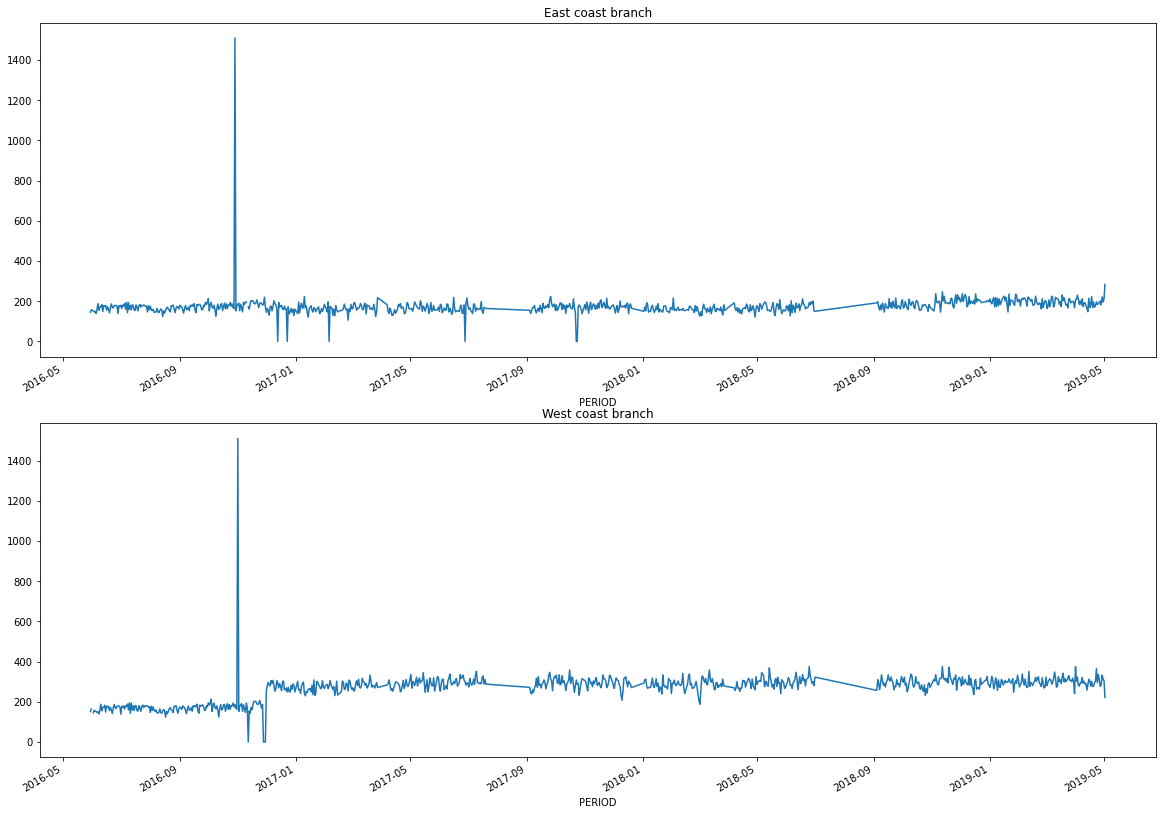

In [32]:
fig,ax = plt.subplots(2,1,figsize=(20,15))
for i,column in enumerate([col for col in SalesQ.columns]):
    SalesQ[column].plot(ax=ax[i])
    ax[i].set_title(column)

In [35]:
from pandas import DataFrame
from pandas import concat

In [36]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

In [37]:
data = series_to_supervised(SalesQ, 5, 7)

In [38]:
data.head()

,var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),...,var1(t+2),var2(t+2),var1(t+3),var2(t+3),var1(t+4),var2(t+4),var1(t+5),var2(t+5),var1(t+6),var2(t+6)
PERIOD,,,,,,,,,,,,,,,,,,,,,
2016-06-07,152.0,145.0,147.0,158.0,150.0,154.0,139.0,152.0,163.0,147.0,...,172.0,163.0,173.0,188.0,183.0,155.0,149.0,172.0,179.0,173.0
2016-06-08,147.0,158.0,150.0,154.0,139.0,152.0,163.0,147.0,188.0,150.0,...,173.0,188.0,183.0,155.0,149.0,172.0,179.0,173.0,175.0,183.0
2016-06-09,150.0,154.0,139.0,152.0,163.0,147.0,188.0,150.0,155.0,139.0,...,183.0,155.0,149.0,172.0,179.0,173.0,175.0,183.0,179.0,149.0
2016-06-10,139.0,152.0,163.0,147.0,188.0,150.0,155.0,139.0,172.0,163.0,...,149.0,172.0,179.0,173.0,175.0,183.0,179.0,149.0,156.0,179.0
2016-06-11,163.0,147.0,188.0,150.0,155.0,139.0,172.0,163.0,173.0,188.0,...,179.0,173.0,175.0,183.0,179.0,149.0,156.0,179.0,172.0,175.0


In [39]:
values = SalesQ.values

In [40]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler

In [41]:
# integer encode direction
encoder = LabelEncoder()
values[:,1] = encoder.fit_transform(values[:,1])

In [42]:
# ensure all data is float
values = values.astype('float32')

In [43]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [44]:
# frame as supervised learning
reframed = series_to_supervised(scaled, 5, 7)

In [45]:
reframed.head()

,var1(t-5),var2(t-5),var1(t-4),var2(t-4),var1(t-3),var2(t-3),var1(t-2),var2(t-2),var1(t-1),var2(t-1),...,var1(t+2),var2(t+2),var1(t+3),var2(t+3),var1(t+4),var2(t+4),var1(t+5),var2(t+5),var1(t+6),var2(t+6)
5,0.096026,0.061111,0.104636,0.127778,0.101987,1.000000,0.100662,0.038889,0.097351,0.094444,...,0.107947,0.044444,0.124503,0.055556,0.102649,0.016667,0.113907,0.122222,0.114570,0.261111
6,0.104636,0.127778,0.101987,1.000000,0.100662,0.038889,0.097351,0.094444,0.099338,0.072222,...,0.124503,0.055556,0.102649,0.016667,0.113907,0.122222,0.114570,0.261111,0.121192,0.077778
7,0.101987,1.000000,0.100662,0.038889,0.097351,0.094444,0.099338,0.072222,0.092053,0.061111,...,0.102649,0.016667,0.113907,0.122222,0.114570,0.261111,0.121192,0.077778,0.098675,0.172222
8,0.100662,0.038889,0.097351,0.094444,0.099338,0.072222,0.092053,0.061111,0.107947,0.044444,...,0.113907,0.122222,0.114570,0.261111,0.121192,0.077778,0.098675,0.172222,0.118543,0.177778
9,0.097351,0.094444,0.099338,0.072222,0.092053,0.061111,0.107947,0.044444,0.124503,0.055556,...,0.114570,0.261111,0.121192,0.077778,0.098675,0.172222,0.118543,0.177778,0.115894,0.233333


In [46]:
print(reframed.head())

   var1(t-5)  var2(t-5)  var1(t-4)  var2(t-4)  var1(t-3)  var2(t-3)  \
5   0.096026   0.061111   0.104636   0.127778   0.101987   1.000000   
6   0.104636   0.127778   0.101987   1.000000   0.100662   0.038889   
7   0.101987   1.000000   0.100662   0.038889   0.097351   0.094444   
8   0.100662   0.038889   0.097351   0.094444   0.099338   0.072222   
9   0.097351   0.094444   0.099338   0.072222   0.092053   0.061111   

   var1(t-2)  var2(t-2)  var1(t-1)  var2(t-1)  ...  var1(t+2)  var2(t+2)  \
5   0.100662   0.038889   0.097351   0.094444  ...   0.107947   0.044444   
6   0.097351   0.094444   0.099338   0.072222  ...   0.124503   0.055556   
7   0.099338   0.072222   0.092053   0.061111  ...   0.102649   0.016667   
8   0.092053   0.061111   0.107947   0.044444  ...   0.113907   0.122222   
9   0.107947   0.044444   0.124503   0.055556  ...   0.114570   0.261111   

   var1(t+3)  var2(t+3)  var1(t+4)  var2(t+4)  var1(t+5)  var2(t+5)  \
5   0.124503   0.055556   0.102649   0.016667

## Define and Fit Model

In [47]:
values = reframed.values
n_train_days = 730

In [48]:
len(values)

884

In [49]:
train = values[:n_train_days, :]
test = values[n_train_days:, :]

In [50]:
len(train)

730

In [51]:
len(test)

154

In [52]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [53]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(730, 23) (730,) (154, 23) (154,)


**Important** We need to reshape input to be 3D structures.reshape input to be 3D (samples, timesteps, features) 

We add a dimension (timesteps) i order to be a 3D array

In [54]:
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))

In [55]:
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(730, 1, 23) (730,) (154, 1, 23) (154,)


In [56]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

In [57]:
from tensorflow.keras import layers

In [58]:
model = Sequential()
model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

### Display model Summary

In [59]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 50)                14800     
_________________________________________________________________
dense (Dense)                (None, 1)                 51        
Total params: 14,851
Trainable params: 14,851
Non-trainable params: 0
_________________________________________________________________


### Compile model 

In [73]:
## Then we compile the keras model
# Model compile step specifies the loss function and the optimizer to use 
model.compile(loss='mean_squared_error',optimizer='adam',
             metrics=['accuracy'])

### Fit the model

In [84]:
# fit the keras model on the dataset
history = model.fit(train_X, train_y, epochs=1000,
                    validation_data=(test_X,test_y))

Epoch 1/1000
23/23 [==============================] - 1s 22ms/step - loss: 0.0100 - accuracy: 0.0041 - val_loss: 0.0169 - val_accuracy: 0.0000e+00
Epoch 2/1000
23/23 [==============================] - 0s 15ms/step - loss: 0.0101 - accuracy: 0.0041 - val_loss: 0.0182 - val_accuracy: 0.0000e+00
Epoch 3/1000
23/23 [==============================] - 0s 14ms/step - loss: 0.0101 - accuracy: 0.0041 - val_loss: 0.0181 - val_accuracy: 0.0000e+00
Epoch 4/1000
23/23 [==============================] - 0s 15ms/step - loss: 0.0101 - accuracy: 0.0041 - val_loss: 0.0173 - val_accuracy: 0.0000e+00
Epoch 5/1000
23/23 [==============================] - 0s 13ms/step - loss: 0.0100 - accuracy: 0.0041 - val_loss: 0.0168 - val_accuracy: 0.0000e+00
Epoch 6/1000
23/23 [==============================] - 0s 14ms/step - loss: 0.0102 - accuracy: 0.0041 - val_loss: 0.0175 - val_accuracy: 0.0000e+00
Epoch 7/1000
23/23 [==============================] - 0s 15ms/step - loss: 0.0104 - accuracy: 0.0041 - val_loss: 0.018

In [85]:
### Plot history

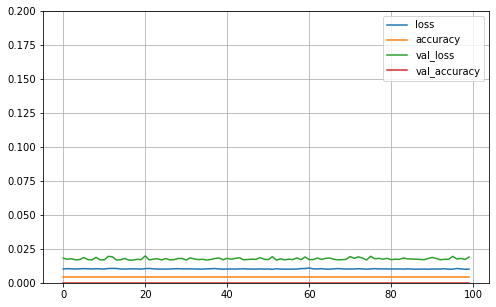

In [81]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid(True)
## Change scale
plt.gca().set_ylim(0,0.2) # This sets vertical range to [0-1]
plt.show()

### Lilst all data in history

In [77]:
print(history.history.keys())

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


In [78]:
import matplotlib.pyplot as plt

## OUTPUTS

### 1. Model accuracy after 100 epochs

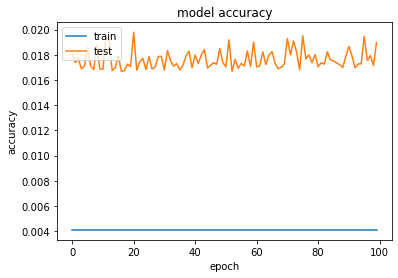

In [82]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy 100 epochs')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc ='upper left')
plt.show()

### 1. Model accuracy after 1000 epochs

The accuracy of a model is usually determined after the model parameters and is calculated in the form of a percentage. It is the measure of how accurate your model's prediction is compared to the true data.

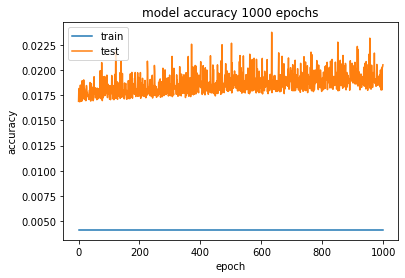

In [86]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_loss'])
plt.title('model accuracy 1000 epochs')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','test'],loc ='upper left')
plt.show()

### 2. Model loss

Loss is the penalty for a bad prediction. That is, loss is a number indicating how bad the model's prediction was on a single example. If the model's prediction is perfect, the loss is zero; otherwise, the loss is greater

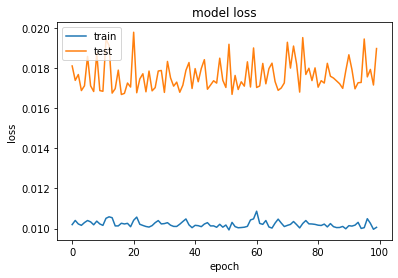

In [83]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','test'],loc ='upper left')
plt.show()

### 3.make some predictions with the model

In [93]:
predictions = model.predict(test_X)

In [94]:
predictions

array([[0.91739947],
       [0.7054231 ],
       [0.6653596 ],
       [0.79022413],
       [0.8708641 ],
       [0.8176847 ],
       [0.7708761 ],
       [0.7865665 ],
       [0.7443285 ],
       [0.7019307 ],
       [0.9033189 ],
       [0.7470764 ],
       [0.74653786],
       [0.7078511 ],
       [0.8087446 ],
       [0.7402153 ],
       [0.7493237 ],
       [0.6717622 ],
       [0.62362033],
       [0.617073  ],
       [0.91319185],
       [0.82197154],
       [0.69694847],
       [0.5479329 ],
       [0.63224125],
       [0.5794459 ],
       [0.82010674],
       [0.76230955],
       [0.70298666],
       [0.6651726 ],
       [0.77699363],
       [0.68887544],
       [0.7227378 ],
       [0.6318468 ],
       [0.73501277],
       [0.8096943 ],
       [0.84833133],
       [0.6571935 ],
       [0.65933704],
       [0.71448797],
       [0.75978434],
       [0.618453  ],
       [0.8435691 ],
       [0.6196275 ],
       [0.64100695],
       [0.8701773 ],
       [0.78300387],
       [0.707

In [95]:
type(predictions)

numpy.ndarray

In [101]:
predictions.shape

(154, 1)

### 4 Unscale the data to revert normalization by MinMazScaler. We can get the error below

We need to unscale the data so it is not normalized as before, we normalized the data using MinMaxscaler to bound its values between 0 and 1 to create our neural network

In [102]:
predictions_unscaled=scaler.inverse_transform(predictions)

ValueError: non-broadcastable output operand with shape (154,1) doesn't match the broadcast shape (154,2)

### How to fix this error

This is a commmon error in Python due to broadcasting. This is how you solve it: 
https://stackoverflow.com/questions/41669995/python-valueerror-non-broadcastable-output-operand-with-shape-124-1-doesnt-m
https://stackoverflow.com/questions/47493559/valueerror-non-broadcastable-output-operand-with-shape-3-1-doesnt-match-the/47493938

In [ ]:
a = np.ones((3,1))

In [106]:
b = np.random.randint(1,10, (154,2))

In [107]:
predictions2=predictions+b

In [108]:
predictions2.shape

(154, 2)

We repeat the inverse_transform process

In [109]:
predictions_unscaled=scaler.inverse_transform(predictions2)

In [111]:
predictions_unscaled.shape

(154, 2)

### 5 Flatten unscaled predictions

Now we can flatten our predictions file

In [116]:
predictions_flat = predictions_unscaled.flatten()

In [117]:
predictions_flat.shape

(308,)

### 6 Plot the unscaled predictions

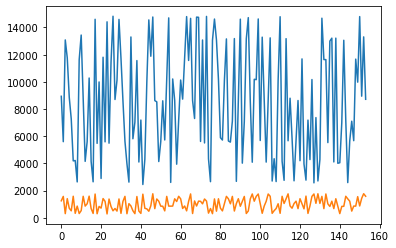

In [118]:

plt.plot(predictions_unscaled)

In [115]:
len(predictions_unscaled)

154

### 7 Match prediction index with validation data to plot it

Take care of the length of train and test data

In [125]:
type(test_y)

numpy.ndarray

Turn  test_y it into a Series

In [129]:
test_y_series = pd.Series(test_y)

In [131]:
len(test_y_series)

154

In [132]:
len(predictions_flat)

308

In [135]:
predictions_flat2 =predictions_flat[0:154]

In [136]:
len(predictions_flat2)

154

In [137]:
predictions_unscaled2 = pd.Series(predictions_flat2, 
                                 # index=valdataf.index[5:])
                                index=test_y_series.index)

In [144]:
test_X

array([[[0.12913908, 0.7111111 , 0.12715232, ..., 0.15364239,
         0.8888889 , 0.12582782]],

       [[0.12715232, 0.79444444, 0.12450331, ..., 0.12582782,
         0.47777778, 0.15364239]],

       [[0.12450331, 0.67222226, 0.12715232, ..., 0.15364239,
         0.7       , 0.1384106 ]],

       ...,

       [[0.11192053, 0.5777778 , 0.12980133, ..., 0.14701986,
         0.8888889 , 0.12980133]],

       [[0.12980133, 0.5777778 , 0.11324503, ..., 0.12980133,
         0.78888893, 0.1397351 ]],

       [[0.11324503, 0.67777777, 0.11721855, ..., 0.1397351 ,
         0.7277778 , 0.18807948]]], dtype=float32)

In [146]:
test_X_flatten = test_X.flatten()

In [147]:
len(test_X_flatten)

3542

In [148]:
test_X_series = pd.Series(test_X_flatten)

In [150]:
test_X_series

0       0.129139
1       0.711111
2       0.127152
3       0.794444
4       0.124503
          ...   
3537    0.129801
3538    0.788889
3539    0.139735
3540    0.727778
3541    0.188079
Length: 3542, dtype: float32

In [151]:
forecastNEURAL = pd.Series(predictions_unscaled2, index = test_X_series.index)

In [152]:
forecastNEURAL_rename = forecastNEURAL.rename('Training Neural Network forecast')

### 8 Plot results

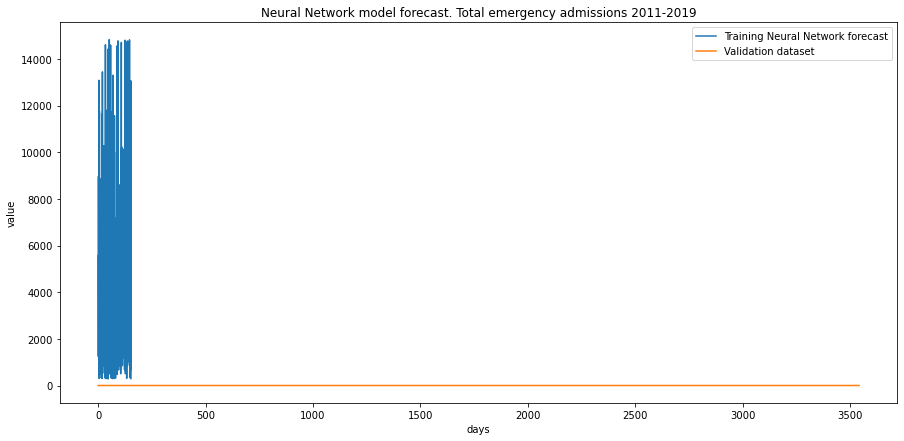

In [153]:
plt.figure(figsize=(15,7))
plt.title('Neural Network model forecast. Total emergency admissions 2011-2019')
#plt.plot(traindataf, label = "Training dataset")  # Dataset 
forecastNEURAL_rename.plot() # Series 
plt.plot(test_X_series, label = "Validation dataset") # Dataset
plt.legend()
plt.ylabel("value")
plt.xlabel("days")
plt.show()

### 9. Compute MAPE value (Homework)

In [ ]:
def accuray_MAPE(ACT,FCAST):
  #  Value = abs((ACT-FCAST)/ACT).sum()/len(ACT)
    Value_percent = (abs((ACT-FCAST)/ACT).sum()/len(ACT))*100
    Mape_value = print(f"Neural Network model MAPE percent   {Value_percent}")
    #Mape_value_per = print(f"Seasonal ARIMA model MAPE {Value}")
    return Value_percent